*Материалы предоставлены авторами курсов Высшей Школы Экономики*

## Парсинг зависимостей
(Depencency parsing)

### Что это?

* наша цель -- представить предложение естественного языка в виде дерева
* слова предложения -- вершины; *зависимости (dependencies)* между ними -- рёбра
* зависимости могут быть разными: например, субъект глагола, объект глагола, прилагательное-модификатор, и так далее

### Формат

Существует несколько форматов записи деревьев зависимостей, но самый популярный и общеиспользуемый -- [CoNLL-U](http://universaldependencies.org/format.html).<br/>
Как это выглядит (пример из [русского Universal Dependency трибанка](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)):

In [1]:
my_example = """
# sent_id = 2003Armeniya.xml_138
# text = Перспективы развития сферы высоких технологий.
1	Перспективы	перспектива	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur	0	ROOT	0:root	_
2	развития	развитие	NOUN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	1	nmod	1:nmod	_
3	сферы	сфера	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	2:nmod	_
4	высоких	высокий	ADJ	_	Case=Gen|Degree=Pos|Number=Plur	5	amod	5:amod	_
5	технологий	технология	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur	3	nmod	3:nmod	SpaceAfter=No
6	.	.	PUNCT	_	_	1	punct	1:punct	_
"""

Комментарии + таблица c 9 колонками (разделены табуляцией):
* ID
* FORM: токен
* LEMMA: начальная форма
* UPOS: универсальная часть речи
* XPOS: лингво-специфичная часть речи
* FEATS: морфологическая информация: падеж, род, число etc
* HEAD: id ролителя
* DEPREL: тип зависимости, то есть отношение к токену-родителю
* DEPS: альтернативный подграф 
* MISC: всё остальное

Отсутствующие данные представляются с помощью `_`. Больше подробностей про формат -- в [официальной документации](http://universaldependencies.org/format.html).<br>

Отрытый инструмент для визуализации, ручной разметки и конвертации в другие форматы: UD Annotatrix. [Online-интерфейс](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), [репозиторий](https://github.com/jonorthwash/ud-annotatrix).

Трибанк - размеченный набор данных, содержит предложения, разделенные пустой строкой.
### Как считывать данные в питоне

Используем библиотеку [conllu](https://github.com/EmilStenstrom/conllu).

In [2]:
%pip install conllu

Note: you may need to restart the kernel to use updated packages.


In [3]:
from conllu import parse

sentences = parse(my_example)
sentence = sentences[0]
sentence[0]

{'id': 1,
 'form': 'Перспективы',
 'lemma': 'перспектива',
 'upos': 'NOUN',
 'xpos': None,
 'feats': {'Animacy': 'Inan',
  'Case': 'Nom',
  'Gender': 'Fem',
  'Number': 'Plur'},
 'head': 0,
 'deprel': 'ROOT',
 'deps': [('root', 0)],
 'misc': None}

In [4]:
sentence[-1]

{'id': 6,
 'form': '.',
 'lemma': '.',
 'upos': 'PUNCT',
 'xpos': None,
 'feats': None,
 'head': 1,
 'deprel': 'punct',
 'deps': [('punct', 1)],
 'misc': None}

## Визуализация

В nltk есть DependencyGraph, который умеет рисовать деревья (и ещё многое другое). Для того, чтобы визуализация работала корректно, ему нужна зависимость: graphviz.

При установке graphviz через pip можно столкнуться с трудностями, большая их часть описана в [официальной документации](https://graphviz.org/download/).<br>

В отличие от `conllu`, `DependencyGraph` не справляется с комментариями, поэтому придётся их убрать. Кроме того, ему обязательно нужен `deprel` *ROOT* в верхнем регистре, иначе он не находит корень.

In [5]:
from nltk import DependencyGraph

sents = []
for sent in my_example.split('\n\n'):
    # убираем комментарии
    sent = '\n'.join([line for line in sent.split('\n') if not line.startswith('#')])
    # заменяем deprel для root
    sent = sent.replace('\troot\t', '\tROOT\t')
    sents.append(sent)

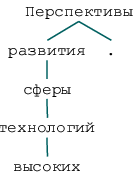

In [6]:
graph = DependencyGraph(tree_str=sents[0])
graph.tree()

In [7]:
tree = graph.tree()
print(tree.pretty_print())

    Перспективы           
  _______|__________       
 |               развития 
 |                  |      
 |                сферы   
 |                  |      
 |              технологий
 |                  |      
 .               высоких  

None


## UDPipe

Есть разные инструменты для парсинга зависимостей. Сегодня мы посмотрим на [UDPipe](http://ufal.mff.cuni.cz/udpipe). UDPipe умеет парсить текст с помощью готовых моделей (которые можно скачать [здесь](https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)) и обучать модели на своих трибанках.

В UDPipe есть три вида моделей:
* токенизатор (разделить текст на предложения, предложения на токены, сделать заготовку для CoNLL-U)
* тэггер (лемматизировать, разметить части речи)
* парсер (проставить каждому токену `head` и `deprel`)

Мы сегодня не будем обучать новых моделей (это слишком долго), а используем готовую модель для русского.

### The Python binding

У udpipe есть питон интерфейс. Библиотека довольно [плохо задокументирована](https://pypi.org/project/ufal.udpipe/), но зато можно использовать прямо в питоне :)

In [ ]:
!pip install ufal.udpipe

In [ ]:
!wget https://github.com/jwijffels/udpipe.models.ud.2.0/raw/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe

In [8]:
from ufal.udpipe import Model, Pipeline
model = Model.load("russian-ud-2.0-170801.udpipe") 
model # None в случае неуспешной загрузки

<Swig Object of type 'model *' at 0x7fd0e9459a70>

С помощью UDPipe токенизируем, лематизируем текст, сделаем POS-tagging и синтаксический парсинг.

In [9]:
# использование Pipeline - Pipeline(MODEL, TOKENIZER, TAGGER, PARSER, 'conllu')
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Я смотрел, как Си-лучи мерцают во тьме близ врат Тангейзера. Все эти мгновения исчезнут во времени, как слёзы под дождём."
parsed = pipeline.process(example)
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Я смотрел, как Си-лучи мерцают во тьме близ врат Тангейзера.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	смотрел	смотрел	VERB	VBC	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	2	punct	_	_
4	как	КАК	ADP	IN	_	5	case	_	_
5	Си	СИ	PROPN	NNP	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	8	nsubj	_	SpaceAfter=No
6	-	-	PUNCT	-	_	5	goeswith	_	SpaceAfter=No
7	лучи	ЛУЧ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Plur	5	goeswith	_	_
8	мерцают	мерцают	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin	2	parataxis	_	_
9	во	ВО	ADP	IN	_	10	case	_	_
10	тьме	тьме	NOUN	NN	Animacy=Inan|Case=Loc|Gender=Neut|Number=Sing	8	obl	_	_
11	близ	БЛИЗ	ADP	IN	_	12	case	_	_
12	врат	врат	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Plur	10	nmod	_	_
13	Тангейзера	тангейзера	PROPN	NNP	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	12	nmod	_	SpaceAfter=No
14	.	.	PUNCT	.	_	2	pun

In [10]:
example = "Сократ родился в 469 году до н. э. в семье скульптора Софрониска из Алопек. В молодости Сократ участвовал в нескольких сражениях. В одной из битв Сократ даже спас от смерти своего молодого сослуживца."

parsed = pipeline.process(example)
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Сократ родился в 469 году до н. э. в семье скульптора Софрониска из Алопек.
1	Сократ	Сократ	PROPN	NNP	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing	2	nsubj	_	_
2	родился	РОДИТЬСЯ	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid	0	root	_	_
3	в	В	ADP	IN	_	5	case	_	_
4	469	469	NUM	CD	Case=Nom|NumType=Card	5	nummod:gov	_	_
5	году	ГОД	NOUN	NN	Animacy=Inan|Case=Dat|Gender=Masc|Number=Sing	2	obl	_	_
6	до	ДО	ADP	IN	_	7	case	_	_
7	н	н	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	obl	_	SpaceAfter=No
8	.	.	PUNCT	.	_	9	punct	_	_
9	э	Э	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	7	nmod	_	SpaceAfter=No
10	.	.	PUNCT	.	_	9	punct	_	_
11	в	В	ADP	IN	_	12	case	_	_
12	семье	СЕМЬЯ	NOUN	NN	Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing	2	obl	_	_
13	скульптора	СКУЛЬПТОР	NOUN	NN	Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing	12	nmod	_	_
14	Софрониска	Софрониска	PROPN	NNP	Animacy=Anim|Case=Gen|Gender=Masc|Number=Sin

## SVO-тройки

С помощью синтаксического парсинга можно извлекать из предложений тройки субъект-объект-глагол (SVO, subject-verb-object), которые можно использовать для извлечения информации из текста. 

In [11]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Я обожаю запах напалма по утрам!"
sent = pipeline.process(example)
print(sent)

# newdoc
# newpar
# sent_id = 1
# text = Я обожаю запах напалма по утрам!
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	обожаю	обожаю	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
3	запах	ЗАПАХ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	obj	_	_
4	напалма	АЛМнапа	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	3	nmod	_	_
5	по	ПО	ADP	IN	_	6	case	_	_
6	утрам	утрам	NOUN	NN	Animacy=Inan|Case=Dat|Gender=Masc|Number=Plur	3	nmod	_	SpaceAfter=No
7	!	!	PUNCT	.	_	2	punct	_	SpacesAfter=\n




In [12]:
sent = '\n'.join([line for line in sent.split('\n') if not line.startswith('#')])
sent = sent.replace('\troot\t', '\tROOT\t').strip()
print(sent)

1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	обожаю	обожаю	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	ROOT	_	_
3	запах	ЗАПАХ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	obj	_	_
4	напалма	АЛМнапа	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	3	nmod	_	_
5	по	ПО	ADP	IN	_	6	case	_	_
6	утрам	утрам	NOUN	NN	Animacy=Inan|Case=Dat|Gender=Masc|Number=Plur	3	nmod	_	SpaceAfter=No
7	!	!	PUNCT	.	_	2	punct	_	SpacesAfter=\n


In [13]:
graph = DependencyGraph(tree_str=sent)
list(graph.triples())

[(('обожаю', 'VERB'), 'nsubj', ('Я', 'PRON')),
 (('обожаю', 'VERB'), 'obj', ('запах', 'NOUN')),
 (('запах', 'NOUN'), 'nmod', ('напалма', 'NOUN')),
 (('запах', 'NOUN'), 'nmod', ('утрам', 'NOUN')),
 (('утрам', 'NOUN'), 'case', ('по', 'ADP')),
 (('обожаю', 'VERB'), 'punct', ('!', 'PUNCT'))]

In [14]:
def get_sov(sent):
    graph = DependencyGraph(tree_str=sent)
    sov = {}
    for triple in graph.triples():
        if triple:
            if triple[0][1] == 'VERB':
                sov[triple[0][0]] = {'subj':'','obj':''}
    for triple in graph.triples():
        if triple:
            if triple[1] == 'nsubj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['subj'] = triple[2][0]
            if triple[1] == 'obj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['obj'] = triple[2][0]
    return sov

sov = get_sov(sent)
print(sov)

{'обожаю': {'subj': 'Я', 'obj': 'запах'}}


### Natasha

Natasha так же умеет делать синтаксический парсинг для русского языка:

In [ ]:
!pip install natasha

In [15]:
from natasha import Doc, NewsEmbedding, NewsSyntaxParser, Segmenter

example = "Я смотрел, как Си-лучи мерцают во тьме близ врат Тангейзера. Все эти мгновения исчезнут во времени, как слёзы под дождём. "
doc = Doc(example)
doc

Doc(text='Я смотрел, как Си-лучи мерцают во тьме близ врат ...)

In [16]:
segmenter = Segmenter()

doc.segment(segmenter)
doc.sents

[DocSent(stop=60, text='Я смотрел, как Си-лучи мерцают во тьме близ врат ..., tokens=[...]),
 DocSent(start=61, stop=121, text='Все эти мгновения исчезнут во времени, как слёзы ..., tokens=[...])]

In [17]:
emb = NewsEmbedding()
syntax_parser = NewsSyntaxParser(emb)

doc.parse_syntax(syntax_parser)
display(doc.tokens)

[DocToken(stop=1, text='Я', id='1_1', head_id='1_2', rel='nsubj'),
 DocToken(start=2, stop=9, text='смотрел', id='1_2', head_id='1_0', rel='root'),
 DocToken(start=9, stop=10, text=',', id='1_3', head_id='1_6', rel='punct'),
 DocToken(start=11, stop=14, text='как', id='1_4', head_id='1_6', rel='mark'),
 DocToken(start=15, stop=22, text='Си-лучи', id='1_5', head_id='1_6', rel='obj'),
 DocToken(start=23, stop=30, text='мерцают', id='1_6', head_id='1_2', rel='ccomp'),
 DocToken(start=31, stop=33, text='во', id='1_7', head_id='1_10', rel='case'),
 DocToken(start=34, stop=38, text='тьме', id='1_8', head_id='1_6', rel='obl'),
 DocToken(start=39, stop=43, text='близ', id='1_9', head_id='1_10', rel='case'),
 DocToken(start=44, stop=48, text='врат', id='1_10', head_id='1_11', rel='amod'),
 DocToken(start=49, stop=59, text='Тангейзера', id='1_11', head_id='1_10', rel='nmod'),
 DocToken(start=59, stop=60, text='.', id='1_12', head_id='1_2', rel='punct'),
 DocToken(start=61, stop=64, text='Все', i

Natasha предоставляет удобный инструмент визуализации

In [18]:
doc.sents[0].syntax.print()

        ┌► Я          nsubj
┌─┌─────└─ смотрел    
│ │ ┌────► ,          punct
│ │ │ ┌──► как        mark
│ │ │ │ ┌► Си-лучи    obj
│ └►└─└─└─ мерцают    ccomp
│ ┌►│      во         case
│ │ └────► тьме       obl
│ │     ┌► близ       case
│ └─┌─┌►└─ врат       amod
│   └►└─── Тангейзера nmod
└────────► .          punct


In [19]:
doc.sents[0].syntax

SyntaxMarkup(
    tokens=[SyntaxToken(
         id='1_1',
         text='Я',
         head_id='1_2',
         rel='nsubj'
     ),
     SyntaxToken(
         id='1_2',
         text='смотрел',
         head_id='1_0',
         rel='root'
     ),
     SyntaxToken(
         id='1_3',
         text=',',
         head_id='1_6',
         rel='punct'
     ),
     SyntaxToken(
         id='1_4',
         text='как',
         head_id='1_6',
         rel='mark'
     ),
     SyntaxToken(
         id='1_5',
         text='Си-лучи',
         head_id='1_6',
         rel='obj'
     ),
     SyntaxToken(
         id='1_6',
         text='мерцают',
         head_id='1_2',
         rel='ccomp'
     ),
     SyntaxToken(
         id='1_7',
         text='во',
         head_id='1_10',
         rel='case'
     ),
     SyntaxToken(
         id='1_8',
         text='тьме',
         head_id='1_6',
         rel='obl'
     ),
     SyntaxToken(
         id='1_9',
         text='близ',
         head_id='1_10',
     

In [20]:
svo = {}

for t in list(doc.sents[0].syntax)[0]:
    tok = list(t)
    if tok[-1] == 'root':
        svo['verb'] = {'text': tok[1], 'id': tok[0]}

verb_id = svo.get('verb', {}).get('id', None)
if verb_id:
    for t in list(doc.sents[0].syntax)[0]:
        tok = list(t)
        if tok[2] == verb_id:
            if tok[-1] == 'nsubj':
                svo['subj'] = {'text': tok[1], 'id': tok[0]}
            if tok[-1] == 'obj':
                svo['obj'] = {'text': tok[1], 'id': tok[0]}


svo

{'verb': {'text': 'смотрел', 'id': '1_2'}, 'subj': {'text': 'Я', 'id': '1_1'}}

In [21]:
example = "Котёнка с таким именем во дворе ждут одни неприятности."
doc = Doc(example)
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.sents[0].syntax.print()
svo = {}

for t in list(doc.sents[0].syntax)[0]:
    tok = list(t)
    print(tok)
    if tok[-1] == 'root':
        svo['verb'] = {'text': tok[1], 'id': tok[0]}

verb_id = svo.get('verb', {}).get('id', None)
if verb_id:
    for t in list(doc.sents[0].syntax)[0]:
        tok = list(t)
        if tok[2] == verb_id:
            if tok[-1] == 'nsubj':
                svo['subj'] = {'text': tok[1], 'id': tok[0]}
            if tok[-1] == 'obj':
                svo['obj'] = {'text': tok[1], 'id': tok[0]}


svo

  ┌────► Котёнка      nsubj
  │ ┌──► с            case
  │ │ ┌► таким        det
  │ └─└─ именем       
  │   ┌► во           case
  │ ┌►└─ дворе        obl
┌─└─└─── ждут         
│ │   ┌► одни         amod
│ └──►└─ неприятности obj
└──────► .            punct
['1_1', 'Котёнка', '1_7', 'nsubj']
['1_2', 'с', '1_4', 'case']
['1_3', 'таким', '1_4', 'det']
['1_4', 'именем', '1_1', 'nmod']
['1_5', 'во', '1_6', 'case']
['1_6', 'дворе', '1_7', 'obl']
['1_7', 'ждут', '1_0', 'root']
['1_8', 'одни', '1_9', 'amod']
['1_9', 'неприятности', '1_7', 'obj']
['1_10', '.', '1_7', 'punct']


{'verb': {'text': 'ждут', 'id': '1_7'},
 'subj': {'text': 'Котёнка', 'id': '1_1'},
 'obj': {'text': 'неприятности', 'id': '1_9'}}

### Попробуем с помощью синтаксических шаблонов сделать простую суммаризацию текстов.

Возьмем данные Lenta.ru и попробуем извлекать из поля "текст" (text) что-то похожее на поле "заголовок" (title).

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
!gzip -d lenta-ru-news.csv.gz

In [22]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

data = pd.read_csv('lenta-ru-news.csv')
data.sample(3)

,url,title,text,topic,tags
152267,https://lenta.ru/news/2016/03/21/ushakov/,Ушаков упрекнул депутата-националиста в плохом знании латышского языка,"Мэр Риги Нил Ушаков на своей странице в Facebook отчитал за плохое знание латышского языка депутата Сейма от националистического объединения «Все для Латвии!» Яниса Домбраву. Ушаков прокомментировал отказ Домбравы дать интервью Первому балтийскому каналу в Риге на марше в День легионеров СС, 16 марта. Депутат тогда назвал журналистов пропагандистами. Первый балтийский канал формирует вещание на основе российского Первого канала. «Янис Домбрава борется с ""пропогандистами"". Зачем депутату националисту знать правописание иностранных слов? Кстати, ни один из тех, кто прокомментировал или зашерил (разместил на своей странице — прим. «Ленты.ру») пост Домбравы, похоже, тоже не знает, как надо писать ""пропогандист"" или ""пропагандист""», — отметил в своем посте Ушаков. 16 марта Ушаков поблагодар...",Бывший СССР,Прибалтика
184883,https://lenta.ru/news/2015/07/22/heartache/,CocoRosie назвали дату выхода нового альбома,"Сестры Бьянка «Коко» и Сьерра «Рози» Кэседи из американской группы CocoRosie поделились деталями выхода своей новой пластинки, сообщает Pitchfork. Альбом будет называться Heartache City и поступит в продажу 18 сентября. Предыдущий диск под названием Tales Of A GrassWidow вышел в 2013 году. Девушки рассказали, что альбом был записан и скомпонован на их студии на юге Франции с использованием минимума оборудования. Смикшированы композиции были в Аргентине. Также CocoRosie выложили в сеть новый трек Un Beso в живом исполнении. Ранее в июне дуэт опубликовал живую запись заглавной песни нового альбома. В видеоролике, снятом во время работы над пластинкой, слышны отрывки еще двух новых композиций. CocoRosie — американский дуэт, состоящий из сестер Бьянки «Коко» Кэседи и Сьерры «Рози» Кэседи....",Культура,Музыка
145368,https://lenta.ru/news/2016/04/27/seidu/,Леа Сейду и лошадь снялись в рекламе Louis Vuitton,"Французская актриса Леа Сейду, лицо Louis Vuitton, снялась в рекламе новой коллекции модного дома — Pre-Fall 2016. Фоном для съемки стало мексиканское ранчо с розовыми стенами, построенное по проекту архитектора Луиса Баррагана. В одном из кадров фотограф Патрик Демаршелье запечатлел вместе с актрисой обитательницу ранчо — породистую лошадь, сообщается в пресс-релизе, поступившем в редакцию «Ленты.ру» в среду, 27 апреля. Сейду позирует с новыми сумками из современной линии Capucines и из исторической линейки City Steamer, впервые запущенной в 1901 году. Леа Сейду — номинантка премии «Сезар» за фильм «Прекрасная смоковница». Снималась у Ридли Скотта («Робин Гуд»), Вуди Аллена («Полночь в Париже»), Брэда Берда («Миссия невыполнима: Протокол Фантом»). Прославилась главной ролью в фильме А...",Ценности,Явления


Немного модифицируем функцию, извлекающую svo-тройки:
1. Добавим обработку сложных предложений (с более чем одним глаголом)
2. Добавим к тройке дополнения, связанные с субъектом и объектом, например: "директор школы" или "полиция Москвы".

In [23]:
def extract_svo(sent):
 
    svo = {}
    verb_index = 1
    for t in list(sent.syntax)[0]:
        tok = list(t)
        if tok[-1] == 'root':
            svo[verb_index] = {'verb': {'text': tok[1], 'id': tok[0]}}
            verb_index += 1

    for v in range (1, verb_index+1):
        obj_id, subj_id = None, None
        verb_id = svo[v]['verb'].get('id', None)

        if verb_id:
                for t in list(sent.syntax)[0]:
                    tok = list(t)
                    if tok[2] == verb_id:
                        if 'nsubj' in tok[-1]:
                            svo[v]['subj'] = tok[1]
                            subj_id = tok[0]
                        if 'obj' in tok[-1] or 'xcomp' in tok[-1]:
                            svo[v]['obj'] = tok[1]
                            obj_id = tok[0]

        if obj_id or subj_id:
                for t in list(sent.syntax)[0]:
                    tok = list(t)
                    if tok[2] == obj_id:
                        if tok[-1] in ['nmod', 'amod']:
                            svo[v]['obj_mod'] = tok[1]     
                    elif tok[2] == subj_id:
                        if tok[-1] in ['nmod', 'amod']:
                            svo[v]['subj_mod'] = tok[1]

        res = {}
        for tr in svo:
            if 'obj' in svo[tr].keys() or 'subj' in svo[tr].keys():
                res[tr] = svo[tr]

        return res

In [24]:
# для упрощения будем искать только в первом предложении
def extract_title(text, segmenter = segmenter, syntax_parser = syntax_parser):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    first_sentence_svo = extract_svo(doc.sents[0])
    
    return first_sentence_svo

In [25]:
# функция для красивой отрисовки результата
def pretty_svo_print(svo):
    print(svo.get('subj', ''), end = ' ')
    print(svo.get('subj_mod', ''), end = ' ')
    print(svo.get('verb', {}).get('text', ''), end = ' ')
    print(svo.get('obj', ''), end=' ')
    print(svo.get('obj_mod', ''))

In [28]:
for i in range(55, 65):
    print('\ntitle:', data.title[i])
    print('text:',data.text[i].split('.')[0])
    svo = extract_title(data.text[i])
    print('> ', end='')
    for i in svo:
        pretty_svo_print(svo[i])


title: Стало известно официальное название новой церкви на Украине
text: Новая неканоническая церковь, созданная в Киеве на объединительном соборе, будет называться Православной церковью Украины
> церковь неканоническая называться церковью Украины

title: В неудачах российской ядерной «Булавы» обвинили Украину
text: Большое число опытных пусков ракеты Р-30 «Булава» объясняется несовершенством российских средств траекторных измерений, оборудование для которых производилось Украиной
> число пусков объясняется  

title: Зинчук рассказал подробности аварии и призвал водителей к бдительности
text: Гитарист-виртуоз и композитор Виктор Зинчук, госпитализированный после ДТП, рассказал о своем самочувствии
> Гитарист-виртуоз  рассказал  

title: Крещение ребенка грубой силой попало на видео
text: Иерей Свято-Георгиевского женского монастыря в Ессентуках Илия Семилетов отстранен от должности и уволен из Пятигорской епархии за грубо проведенный обряд крещения ребенка
> Иерей монастыря отстранен 

## SyntaxGym

[SyntaxGym](https://syntaxgym.org/) - инструмент для оценки языковых моделей с точки зрения синтаксиса.

* [Пример](https://cpllab.github.io/syntaxgym-core/index.html) оценки модели на своем тестовом кейсе.
* [Коллекция](https://syntaxgym.org/test_suite/) кейсов для оценки моделей на примере различных грамматических явлений.
* [Визуализации](https://syntaxgym.org/viz/) (например, [сравнение моделей](https://syntaxgym.org/viz/compare)\).

# Анализ тональности с рекурсивными нейросетями

* [Пост на медиуме](https://medium.com/@keisukeumezawa/chainer-tutorial-sentiment-analysis-with-recursive-neural-network-180ddde892a2)
* [Статья](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) (архитектура описана в 4 секции)
* Код: [notebook](https://colab.research.google.com/github/chainer-community/chainer-colab-notebook/blob/master/official_example_en/sentiment.ipynb), [репозиторий](https://github.com/chainer/chainer/tree/master/examples/sentiment).


В этой модели используется идея *парсинга составляющих*, или *constituency parsing*. 
![Constituancy parsing](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/constituency_parsing.png)

Суть подхода к анализу тональности -- тональность предложения складывается из тональности его составляющих, их тональность тоже определяется по входящим в них составляющим (и не всегда конечный результат -- это простая сумма тональности частей, как в модели мешка слов).

![Sentiment recursive nn](https://github.com/PragmaticsLab/NLP-course-AMI/raw/dev/seminars/sem5_syntax/sentiment_recursiveNN.png)
